In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pybaseball import statcast
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
sns.set(style="whitegrid", context="talk")
plt.rcParams['figure.figsize'] = (12, 8)

print("Libraries imported successfully!")

Libraries imported successfully!


In [8]:
print("Loading full season Statcast data...")
print("This may take a few minutes...")

# Get full 2024 season (adjust dates as needed)
start_date = "2024-04-01"
end_date = "2024-09-30"

# Load the data
df_season = statcast(start_dt=start_date, end_dt=end_date)

print(f"Loaded {len(df_season):,} total plate appearances")
print(f"Date range: {df_season['game_date'].min()} to {df_season['game_date'].max()}")
print(f"Dataframe shape: {df_season.shape}")
print(f"Available columns: {list(df_season.columns)}")

Loading full season Statcast data...
This may take a few minutes...
This is a large query, it may take a moment to complete


100%|█████████████████████████████████| 183/183 [00:04<00:00, 42.66it/s]


Loaded 692,943 total plate appearances
Date range: 2024-04-01 00:00:00 to 2024-09-30 00:00:00
Dataframe shape: (692943, 118)
Available columns: ['pitch_type', 'game_date', 'release_speed', 'release_pos_x', 'release_pos_z', 'player_name', 'batter', 'pitcher', 'events', 'description', 'spin_dir', 'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 'zone', 'des', 'game_type', 'stand', 'p_throws', 'home_team', 'away_team', 'type', 'hit_location', 'bb_type', 'balls', 'strikes', 'game_year', 'pfx_x', 'pfx_z', 'plate_x', 'plate_z', 'on_3b', 'on_2b', 'on_1b', 'outs_when_up', 'inning', 'inning_topbot', 'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated', 'umpire', 'sv_id', 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'sz_top', 'sz_bot', 'hit_distance_sc', 'launch_speed', 'launch_angle', 'effective_speed', 'release_spin_rate', 'release_extension', 'game_pk', 'fielder_2', 'fielder_3', 'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9', 'release_pos

In [9]:
print("Filtering and cleaning data...")

# Filter to only include batted balls and walks/HBP (things that contribute to wOBA)
woba_events = [
    'single', 'double', 'triple', 'home_run',
    'walk', 'hit_by_pitch', 'intent_walk',
    'field_out', 'strikeout', 'force_out', 'fielders_choice_out',
    'grounded_into_double_play', 'pop_out', 'fly_out', 'lineout'
]

# Filter to relevant events
df_filtered = df_season[df_season['events'].isin(woba_events)].copy()

# Remove rows with missing critical data for batted balls
batted_ball_events = [
    'single', 'double', 'triple', 'home_run',
    'field_out', 'force_out', 'fielders_choice_out',
    'grounded_into_double_play', 'pop_out', 'fly_out', 'lineout'
]

# For batted balls, need launch speed and angle
batted_balls_mask = df_filtered['events'].isin(batted_ball_events)
df_filtered = df_filtered[
    ~batted_balls_mask | 
    (batted_balls_mask & df_filtered['launch_speed'].notna() & df_filtered['launch_angle'].notna())
].copy()

print(f"After filtering: {len(df_filtered):,} plate appearances")
print(f"Events distribution:")
print(df_filtered['events'].value_counts())

Filtering and cleaning data...
After filtering: 173,615 plate appearances
Events distribution:
events
field_out                    71959
strikeout                    40070
single                       25204
walk                         14013
double                        7600
home_run                      5325
force_out                     3374
grounded_into_double_play     3128
hit_by_pitch                  1963
triple                         676
fielders_choice_out            303
Name: count, dtype: int64


In [10]:
print("Using existing wOBA values from Statcast data...")

# Check if woba_value exists, if not calculate it
if 'woba_value' in df_filtered.columns:
    df_filtered['woba_value_actual'] = df_filtered['woba_value'].fillna(0)
    print("Using existing woba_value column")
else:
    print("woba_value column not found, calculating manually...")
    def calculate_woba_value(events):
        woba_weights = {
            'walk': 0.690, 'hit_by_pitch': 0.719, 'intent_walk': 0.690,
            'single': 0.888, 'double': 1.271, 'triple': 1.616, 'home_run': 2.101,
            'field_out': 0.0, 'strikeout': 0.0, 'force_out': 0.0,
            'fielders_choice_out': 0.0, 'grounded_into_double_play': 0.0,
            'pop_out': 0.0, 'fly_out': 0.0, 'lineout': 0.0
        }
        return events.map(woba_weights)
    df_filtered['woba_value_actual'] = calculate_woba_value(df_filtered['events'])

print("Target variable ready:")
print(f"Mean wOBA value: {df_filtered['woba_value_actual'].mean():.3f}")
print(f"Non-zero wOBA values: {(df_filtered['woba_value_actual'] > 0).sum():,}")

Using existing wOBA values from Statcast data...
Using existing woba_value column
Target variable ready:
Mean wOBA value: 0.318
Non-zero wOBA values: 54,831


In [11]:
def create_model_features(df):
    """Create features for xwOBA prediction model"""
    df = df.copy()
    
    # Fill missing values
    df['launch_speed'] = df['launch_speed'].fillna(0)
    df['launch_angle'] = df['launch_angle'].fillna(0) 
    
    # For walks/HBP, we don't have batted ball data, so set to special values
    walk_events = ['walk', 'hit_by_pitch', 'intent_walk']
    walk_mask = df['events'].isin(walk_events)
    
    # Set launch speed/angle to special values for walks (model will learn this pattern)
    df.loc[walk_mask, 'launch_speed'] = -1
    df.loc[walk_mask, 'launch_angle'] = -999
    
    # Additional features
    df['launch_speed_squared'] = df['launch_speed'] ** 2
    df['abs_launch_angle'] = np.abs(df['launch_angle'])
    df['speed_angle_interaction'] = df['launch_speed'] * np.abs(df['launch_angle'])
    
    # Distance from optimal launch angle (around 25-30 degrees for home runs)
    df['optimal_angle_distance'] = np.abs(df['launch_angle'] - 27)
    
    # Is walk indicator
    df['is_walk'] = walk_mask.astype(int)
    
    return df

# Apply feature engineering
df_model = create_model_features(df_filtered)

print("Features created successfully!")
print(f"Total observations: {len(df_model):,}")
print(f"Walks/HBP: {df_model['is_walk'].sum():,}")

Features created successfully!
Total observations: 173,615
Walks/HBP: 15,976


In [12]:
# Define features for the model
feature_columns = [
    'launch_speed',
    'launch_angle', 
    'launch_speed_squared',
    'abs_launch_angle',
    'speed_angle_interaction',
    'optimal_angle_distance',
    'is_walk'
]

# Prepare training data
X = df_model[feature_columns].fillna(0)
y = df_model['woba_value_actual']

print("Model features:")
for i, col in enumerate(feature_columns):
    print(f"{i+1}. {col}")

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"\nTraining set: {len(X_train):,} samples")
print(f"Test set: {len(X_test):,} samples")

# Train the model
print("\nTraining Random Forest model...")
rf_model = RandomForestRegressor(
    n_estimators=500,
    max_depth=15,
    min_samples_split=100,
    min_samples_leaf=50,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)
print("Model training completed!")

Model features:
1. launch_speed
2. launch_angle
3. launch_speed_squared
4. abs_launch_angle
5. speed_angle_interaction
6. optimal_angle_distance
7. is_walk

Training set: 138,892 samples
Test set: 34,723 samples

Training Random Forest model...
Model training completed!


In [13]:
# Make predictions
y_pred = rf_model.predict(X_test)

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mse)

print("Model Performance on Test Set:")
print(f"R² Score: {r2:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MSE: {mse:.4f}")

# Feature importance
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance)

Model Performance on Test Set:
R² Score: 0.5300
RMSE: 0.3506
MSE: 0.1229

Feature Importance:
                   feature  importance
5   optimal_angle_distance    0.291076
2     launch_speed_squared    0.192192
0             launch_speed    0.186202
4  speed_angle_interaction    0.160105
6                  is_walk    0.141627
1             launch_angle    0.020129
3         abs_launch_angle    0.008670


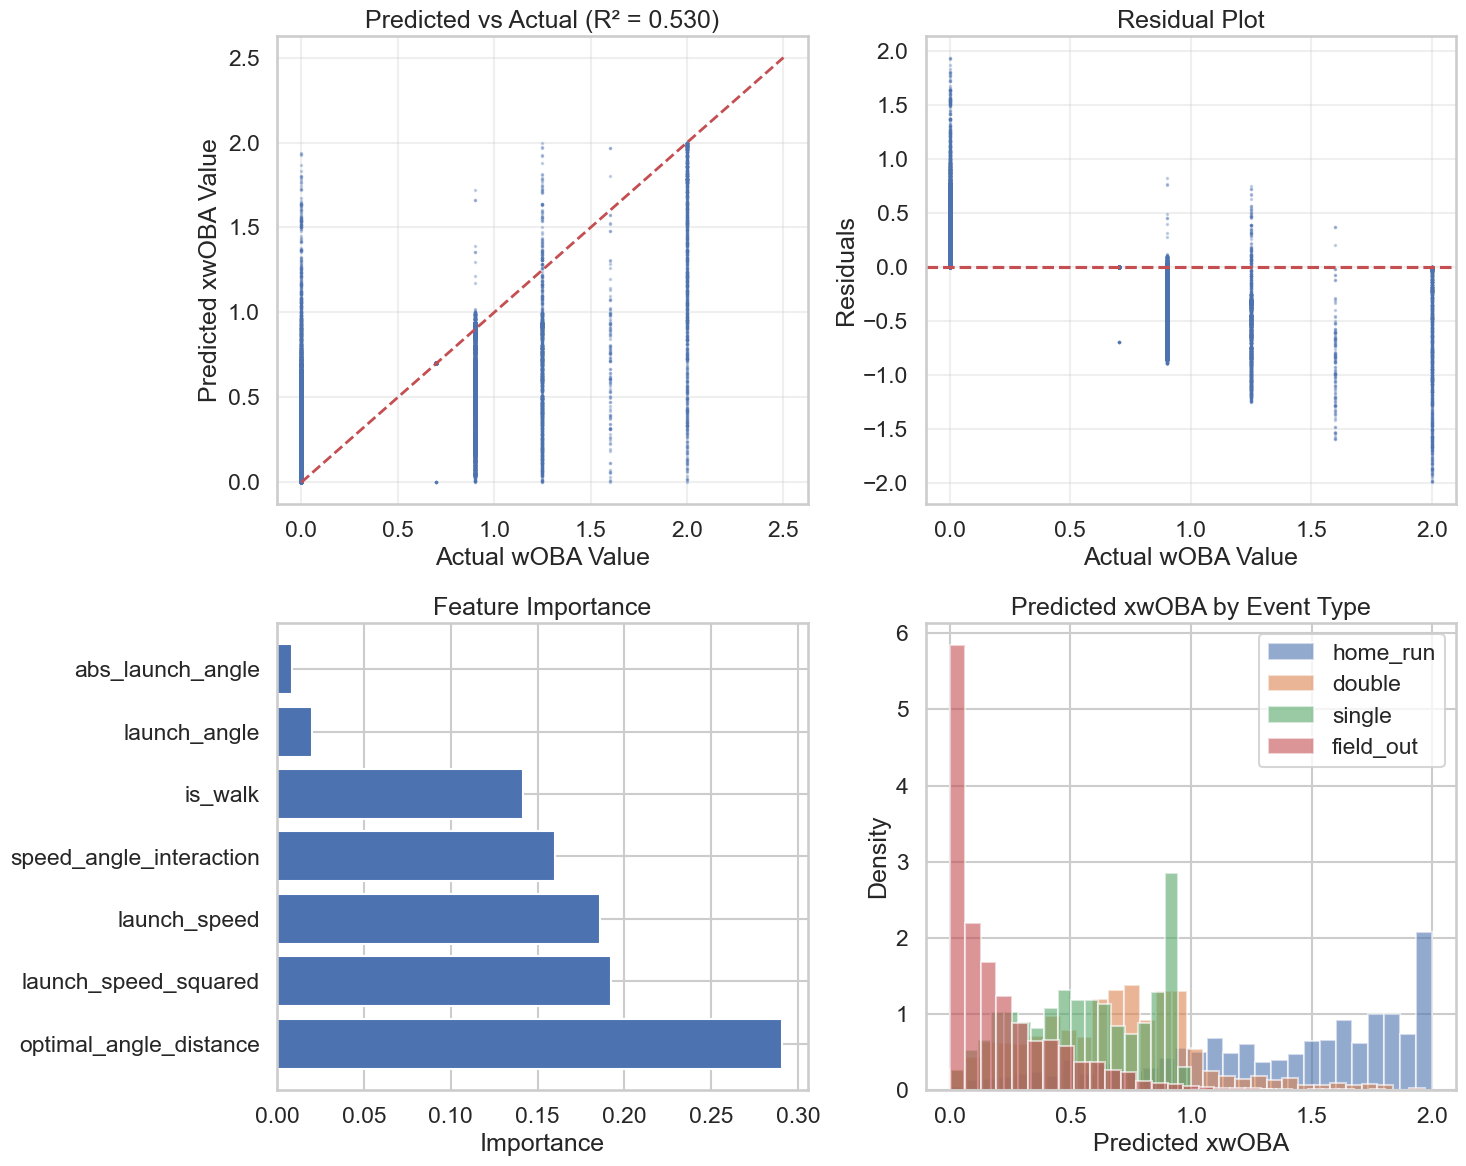

In [14]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Predicted vs Actual
axes[0,0].scatter(y_test, y_pred, alpha=0.3, s=1)
axes[0,0].plot([0, 2.5], [0, 2.5], 'r--', linewidth=2)
axes[0,0].set_xlabel('Actual wOBA Value')
axes[0,0].set_ylabel('Predicted xwOBA Value') 
axes[0,0].set_title(f'Predicted vs Actual (R² = {r2:.3f})')
axes[0,0].grid(True, alpha=0.3)

# 2. Residuals
residuals = y_pred - y_test
axes[0,1].scatter(y_test, residuals, alpha=0.3, s=1)
axes[0,1].axhline(y=0, color='r', linestyle='--')
axes[0,1].set_xlabel('Actual wOBA Value')
axes[0,1].set_ylabel('Residuals')
axes[0,1].set_title('Residual Plot')
axes[0,1].grid(True, alpha=0.3)

# 3. Feature importance
axes[1,0].barh(feature_importance['feature'], feature_importance['importance'])
axes[1,0].set_xlabel('Importance')
axes[1,0].set_title('Feature Importance')

# 4. Distribution of predictions by event type
sample_data = df_model.sample(50000) if len(df_model) > 50000 else df_model
for event in ['home_run', 'double', 'single', 'field_out']:
    if event in sample_data['events'].values:
        event_data = sample_data[sample_data['events'] == event]
        if len(event_data) > 10:
            axes[1,1].hist(rf_model.predict(event_data[feature_columns]), 
                          alpha=0.6, label=event, bins=30, density=True)

axes[1,1].set_xlabel('Predicted xwOBA')
axes[1,1].set_ylabel('Density')
axes[1,1].set_title('Predicted xwOBA by Event Type')
axes[1,1].legend()

plt.tight_layout()
plt.show()

In [15]:
print("Preparing player-level validation...")

# Add predictions to the full model dataset
df_model['xwoba_predicted'] = rf_model.predict(X)

# Filter to players with sufficient plate appearances
min_pa = 200  # Minimum plate appearances

player_stats = df_model.groupby('player_name').agg({
    'woba_value_actual': ['mean', 'count'],
    'xwoba_predicted': 'mean'
}).round(4)

# Flatten column names
player_stats.columns = ['actual_woba', 'plate_appearances', 'predicted_xwoba']
player_stats = player_stats.reset_index()

# Filter to qualified players
qualified_players = player_stats[
    player_stats['plate_appearances'] >= min_pa
].copy()

print(f"Players with {min_pa}+ PA: {len(qualified_players)}")
print(f"Total plate appearances covered: {qualified_players['plate_appearances'].sum():,}")

Preparing player-level validation...
Players with 200+ PA: 356
Total plate appearances covered: 138,178


In [16]:
# Calculate correlation
correlation = qualified_players['actual_woba'].corr(qualified_players['predicted_xwoba'])
player_mse = mean_squared_error(qualified_players['actual_woba'], qualified_players['predicted_xwoba'])
player_rmse = np.sqrt(player_mse)

print("Player-Level Validation Results:")
print(f"Correlation: {correlation:.4f}")
print(f"RMSE: {player_rmse:.4f}")
print(f"MSE: {player_mse:.4f}")

# Show top and bottom players
print(f"\nTop 10 Predicted xwOBA (min {min_pa} PA):")
top_players = qualified_players.nlargest(10, 'predicted_xwoba')
print(top_players[['player_name', 'actual_woba', 'predicted_xwoba', 'plate_appearances']])

print(f"\nBottom 10 Predicted xwOBA (min {min_pa} PA):")
bottom_players = qualified_players.nsmallest(10, 'predicted_xwoba')
print(bottom_players[['player_name', 'actual_woba', 'predicted_xwoba', 'plate_appearances']])

# Biggest prediction errors
qualified_players['abs_error'] = abs(qualified_players['predicted_xwoba'] - qualified_players['actual_woba'])
print(f"\nLargest Prediction Errors:")
error_players = qualified_players.nlargest(10, 'abs_error')
print(error_players[['player_name', 'actual_woba', 'predicted_xwoba', 'abs_error', 'plate_appearances']])

Player-Level Validation Results:
Correlation: 0.8502
RMSE: 0.0201
MSE: 0.0004

Top 10 Predicted xwOBA (min 200 PA):
          player_name  actual_woba  predicted_xwoba  plate_appearances
512     Miller, Bobby       0.4438           0.4175                234
70          Blach, Ty       0.4234           0.4053                321
793   Walker, Taijuan       0.4217           0.4025                374
540    Muñoz, Roddery       0.4081           0.4001                365
423  Lawrence, Justin       0.4028           0.3853                265
347    Hudson, Dakota       0.3677           0.3784                398
13       Allen, Logan       0.3821           0.3757                531
786    Vásquez, Randy       0.3656           0.3735                423
355       Irvin, Cole        0.366           0.3710                480
294  Hancock, Emerson       0.3462           0.3680                261

Bottom 10 Predicted xwOBA (min 200 PA):
           player_name  actual_woba  predicted_xwoba  plate_ap